## Understand The Problem Statement & Business Case

- AI/ML/DL has been revolutionizing healthcare and medicine:
    - Medical imagery 
    - Drug research 
    - Genome development 

- Deep learning has been proven to be superior in detecting and classifying disease using imagery data.

- Skin cancer could be detected more accurately by Deep Learning than by dermatologists (2018). 
    - Human dermatologists detection = 86.6%
    - Deep Learning detection = 95%

Reference: "Computer learns to detect skin cancer more accurately than doctors". The Guardian. 29 May 2018

- In this case study, we will assume that you work as a Deep Learning Consultant. 
- You have been hired by a hospital in downtown Toronto and you have been tasked to automate the process of detecting and classifying chest disease and reduce the cost and time of detection. 
- The team has collected extensive X-Ray chest data and they approached you to develop a model that could detect and classify the diseases in less than 1 minute. 
- You have been provided with 133 images that belong to 4 classes: 
    - Healthy 
    - Covid-19
    - Bacterial Pneumonia
    - Viral Pneumonia

## Import Libraries and Datasets

- This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
- Each class contains 133 images.
- Dataset Source:
    - https://github.com/ieee8023/covid-chestxray-dataset
    - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Specify training data directory
X_Ray_Directory = 'Disease Detection Model/Dataset'

In [3]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['.DS_Store', '0', '1', '3', '2']

In [4]:
# Used image generator to generate tensor images data and normalize them
# Used 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [5]:
# Generated batches of 40 images
# Performed shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [6]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'validation')

Found 104 images belonging to 4 classes.


- Total number of images is 133*4 = 532 images
- Training is 428 (80%) and validation is 104 (20%)

In [7]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
train_labels.shape

(40, 4)

In [10]:
train_labels
# Mathematically showing that each image belongs to one of the four classes

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [11]:
# labels Translator
label_names = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

## Visualize Dataset

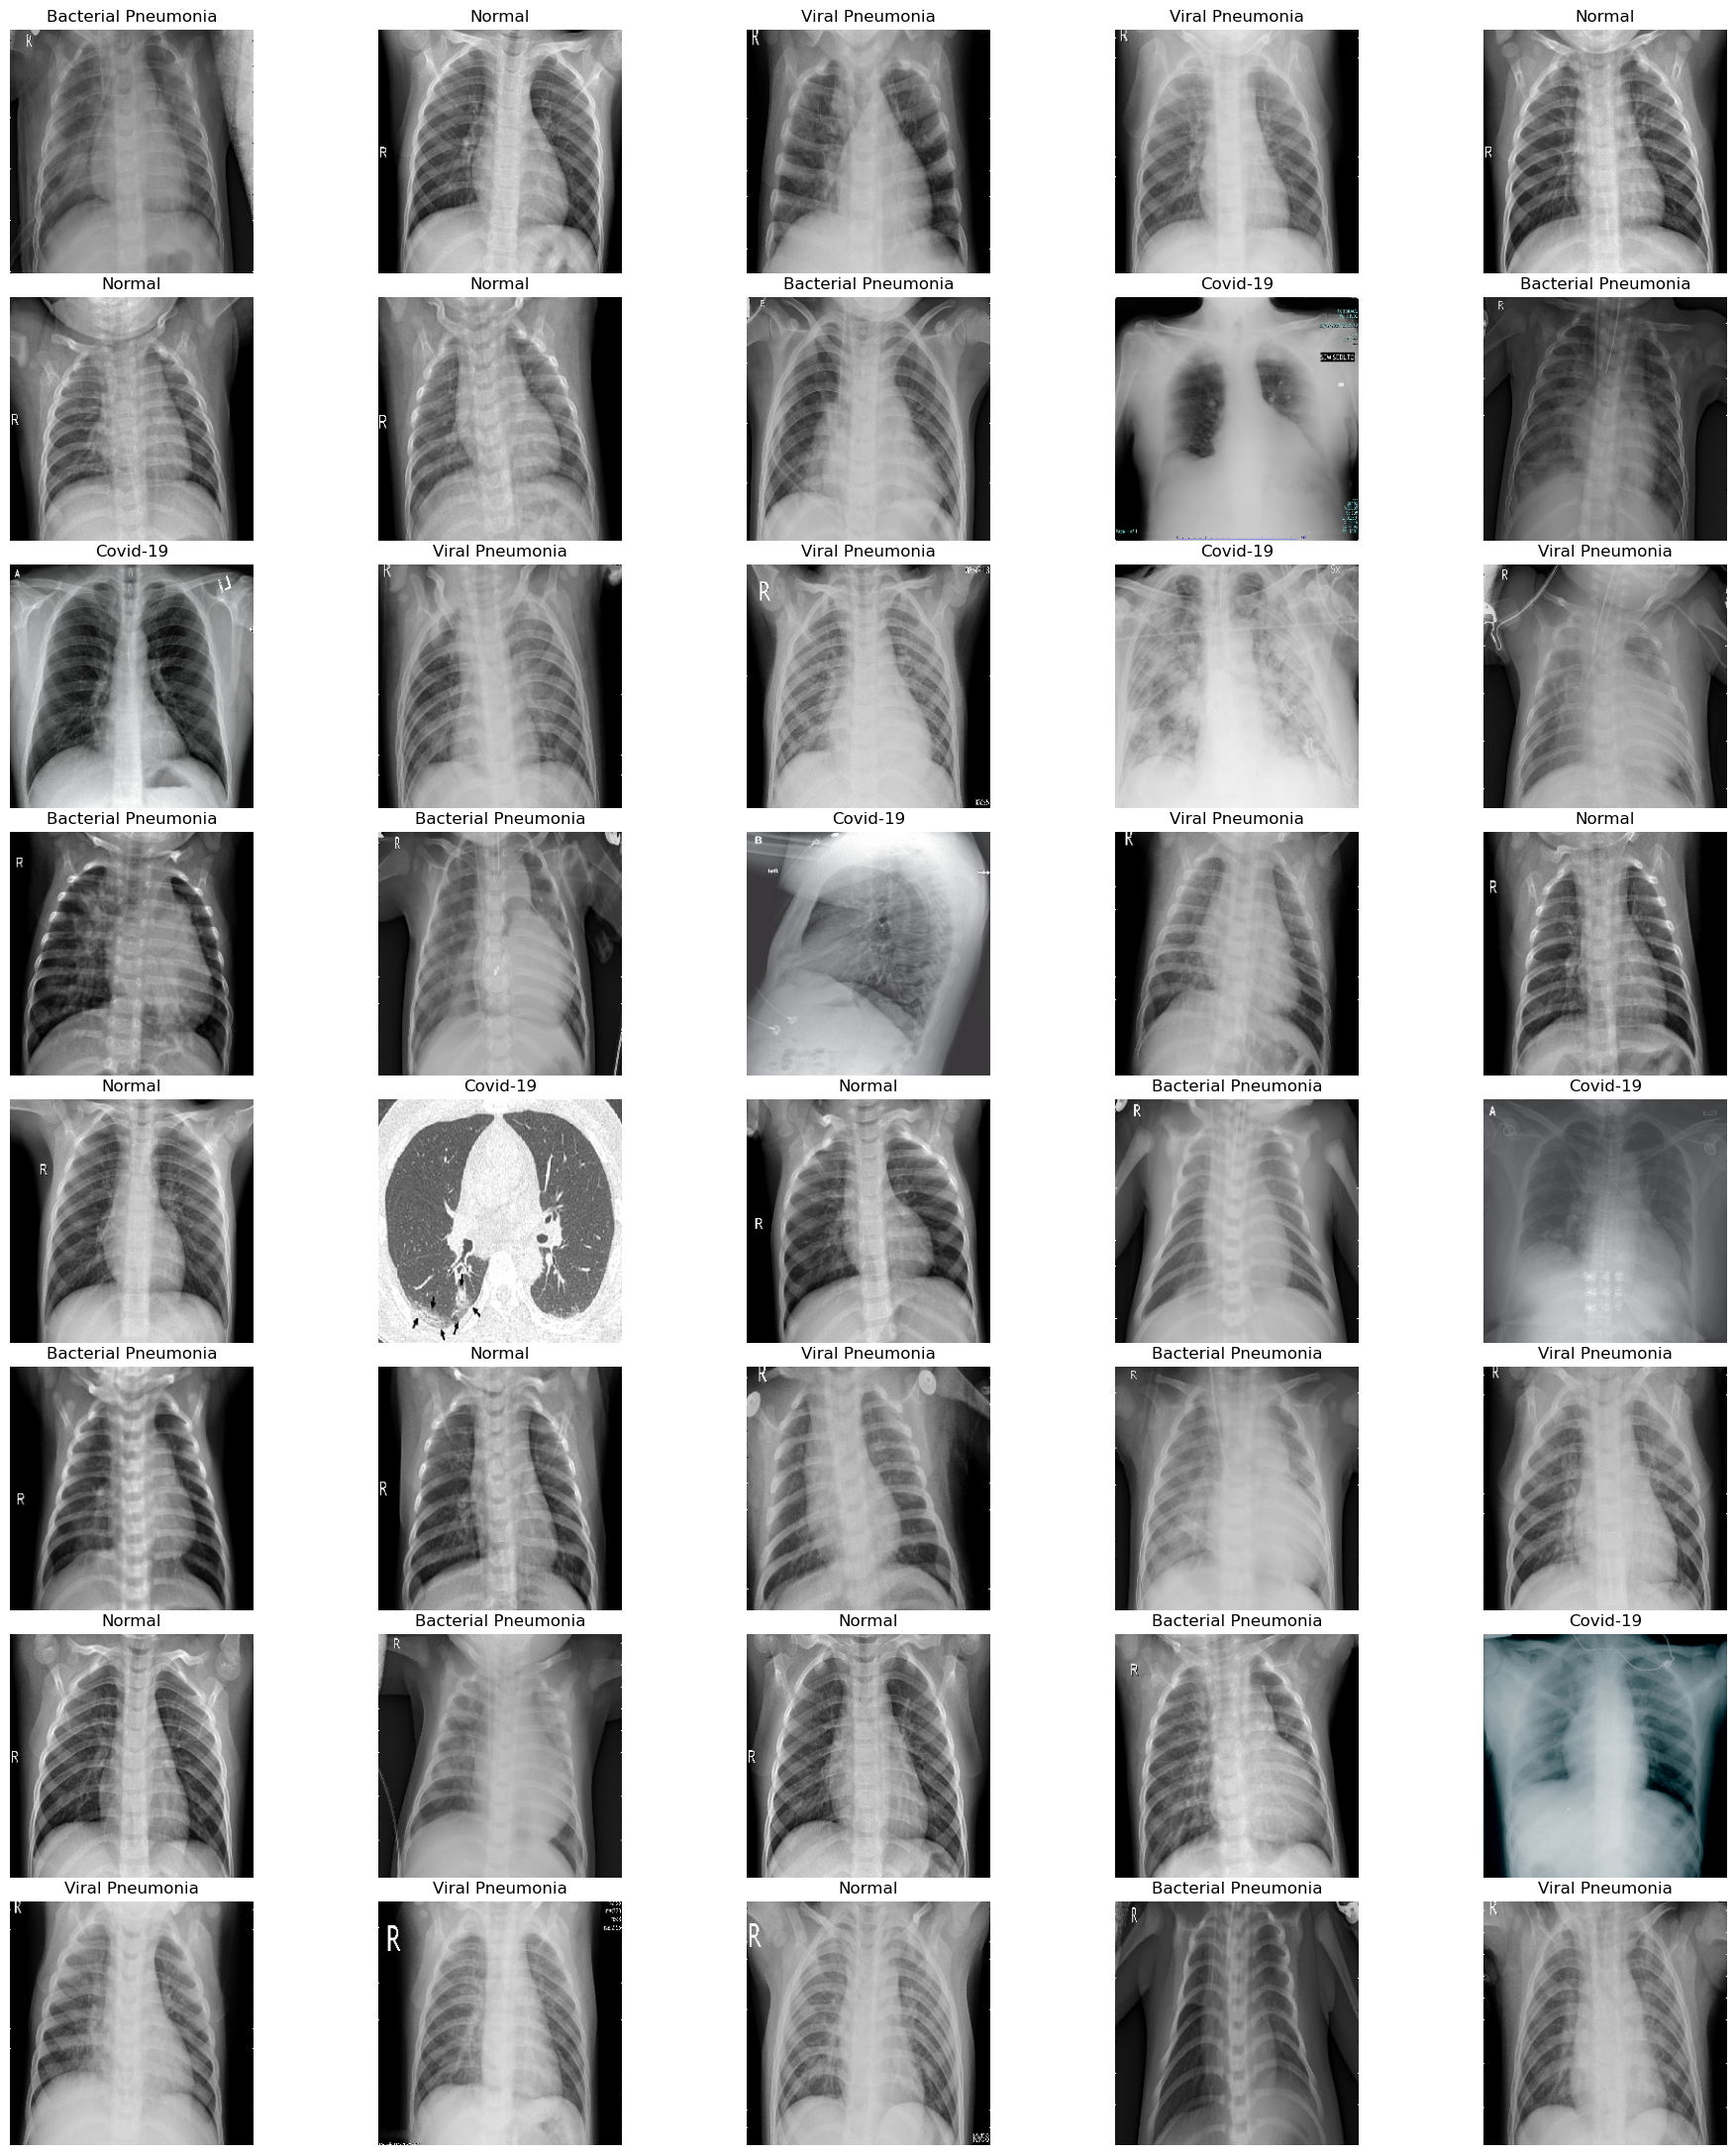

In [12]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0, hspace = 0.1, top = 1)

## Understand the Theory & Intuition Behind Convolutional Neural Networks (CNN)

### Convolutional Neural Networks (CNN):
- The first CNN layers are used to extract high level general features. 
- The last couple of layers are used to perform classification (on a specific task).
- Local respective fields scan the image first searching for simple shapes such as edges/lines 
- These edges are then picked up by the subsequent layer to form more complex features.

### Deep Learning History:

- There are many trained off the shelve convolutional neural networks that are readily available such as: 
    - LeNet-5 (1998): 7 level convolutional neural network developed by LeCun that works in classifying hand writing numbers.
    - AlexNet (2012): Offered massive improvement, error reduction from 26% to 15.3%
    - ZFNEt (2013): achieved error of 14.8%
    - Googlenet/Inception (2014): error reduction to 6.67% which is at par with human level accuracy.
    - VGGNet (2014)
    - ResNet (2015): Residual Neural Network includes “skip connection” feature and therefore enabled training of 152 layers without vanishing gradient issues. Error of 3.57% which is superior than humans. 

Source: https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

### Resnet (Residual Network):

- As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
- Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers which results in a very small gradient. 
- Residual Neural Network includes “skip connection” feature which enables training of 152 layers without vanishing gradient issues. 
- Resnet works by adding “identity mappings” on top of the CNN. 
- ImageNet contains 11 million images and 11,000 categories. 
- ImageNet is used to train ResNet deep network.

## Understand the Theory & Intuition Behind Transfer Learning

### What is Transfer Learning:

- Transfer learning is a machine learning technique in which a network that has been trained to perform a specific task is being reused (repurposed) as a starting point for another similar task.
- Transfer learning is widely used since starting from a pre-trained models can dramatically reduce the computational time required if training is performed from scratch. 


- “Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned”—Transfer Learning, Handbook of Research on Machine Learning Applications, 2009.
- In transfer learning, a base (reference) Artificial Neural Network on a base dataset and function is being trained. Then, this trained network weights are then repurposed in a second ANN to be trained on a new dataset and function. 
- Transfer learning works great if the features are general, such that trained weights can effectively repurposed.
- Intelligence is being transferred from the base network to the newly target network.

### Why Do We Keep the First Layers?

- The first CNN layers are used to extract high level general features. 
- The last couple of layers are used to perform classification (on a specific task).
- So we copy the first trained layers (base model) and then we add a new custom layers in the output to perform classification on a specific new task.

### Transfer Learning Strategies:

- Strategy #1 Steps: 
    - Freeze the trained CNN network weights from the first layers. 
    - Only train the newly added dense layers (with randomly initialized weights).
- Strategy #2 Steps: 
    - Initialize the CNN network with the pre-trained weights 
    - Retrain the entire CNN network while setting the learning rate to be very small, this is critical to ensure that you do not aggressively change the trained weights.
- Transfer learning advantages are:
    - Provides fast training progress, you don’t have to start from scratch using randomly initialized weights
    - You can use small training dataset to achieve incredible results


## Import Model with Pre-trained Weights

In [13]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [14]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
# Freeze the layers (except the last 10 layers)
for layer in basemodel.layers[:-10]:
    layer.trainable = False

## Build & Train Deep Learning Model

In [16]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.1)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

In [17]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [19]:
# Using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.keras', verbose = 1, save_best_only = True)

In [20]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'training')
validation_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [21]:
history = model.fit(train_generator, epochs = 25, validation_data = validation_generator, callbacks = [earlystopping, checkpointer])

Epoch 1/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.2597 - loss: 1.4974
Epoch 1: val_loss improved from inf to 1.32257, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - accuracy: 0.2601 - loss: 1.4965 - val_accuracy: 0.3462 - val_loss: 1.3226
Epoch 2/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.4359 - loss: 1.1415
Epoch 2: val_loss improved from 1.32257 to 1.22736, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 325ms/step - accuracy: 0.4363 - loss: 1.1411 - val_accuracy: 0.3846 - val_loss: 1.2274
Epoch 3/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5738 - loss: 0.9906
Epoch 3: val_loss improved from 1.22736 to 0.93532, saving model to weights.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 31s 292ms/step - accuracy: 0.5740 - loss: 0.9903 - val_accuracy: 0.5865 - val_loss: 0.9353
Epoch 4/25
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6795 - loss: 0.7857
Epoch 4: val_loss did not improve from 0.93532

## Evaluate Trained Deep Learning Model

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

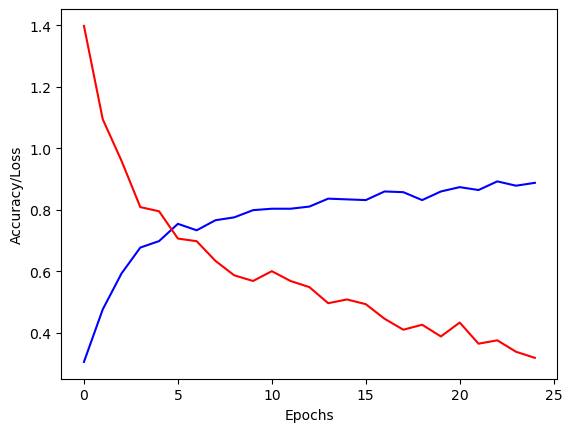

In [23]:
plt.plot(history.history['accuracy'], color = 'blue')
plt.plot(history.history['loss'], color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss');

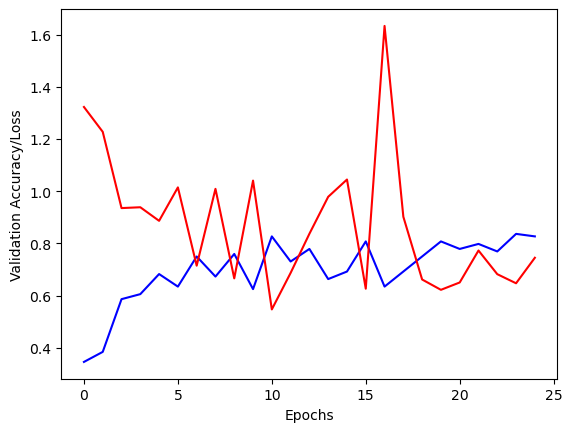

In [24]:
plt.plot(history.history['val_accuracy'], color = 'blue')
plt.plot(history.history['val_loss'], color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy/Loss');

In [ ]:
test_directory = 'Disease Detection Model/Test'

In [26]:
os.listdir(test_directory)

['.DS_Store', '0', '1', '3', '2']

In [27]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, target_size = (256, 256), class_mode = 'categorical', shuffle = True)
evaluate = model.evaluate(test_generator, steps = test_generator.n // 4, verbose = 1)
print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6750 - loss: 1.8555
Accuracy Test : 0.675000011920929


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions =[]
original = []
image = []

for i in os.listdir(test_directory):
    subdir = os.path.join(test_directory, i)
    if os.path.isdir(subdir):
        for item in os.listdir(subdir):
            img = cv2.imread(os.path.join(subdir, item))
            img = cv2.resize(img, (256, 256))
            image.append(img)
            img = img / 255
            img = img.reshape(-1, 256, 256, 3)
            predict = model.predict(img)
            predict = np.argmax(predict)
            predictions.append(predict)
            original.append(int(i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━

In [29]:
score = accuracy_score(original, predictions)
print('Test Accuracy : {}'.format(score))

Test Accuracy : 0.675


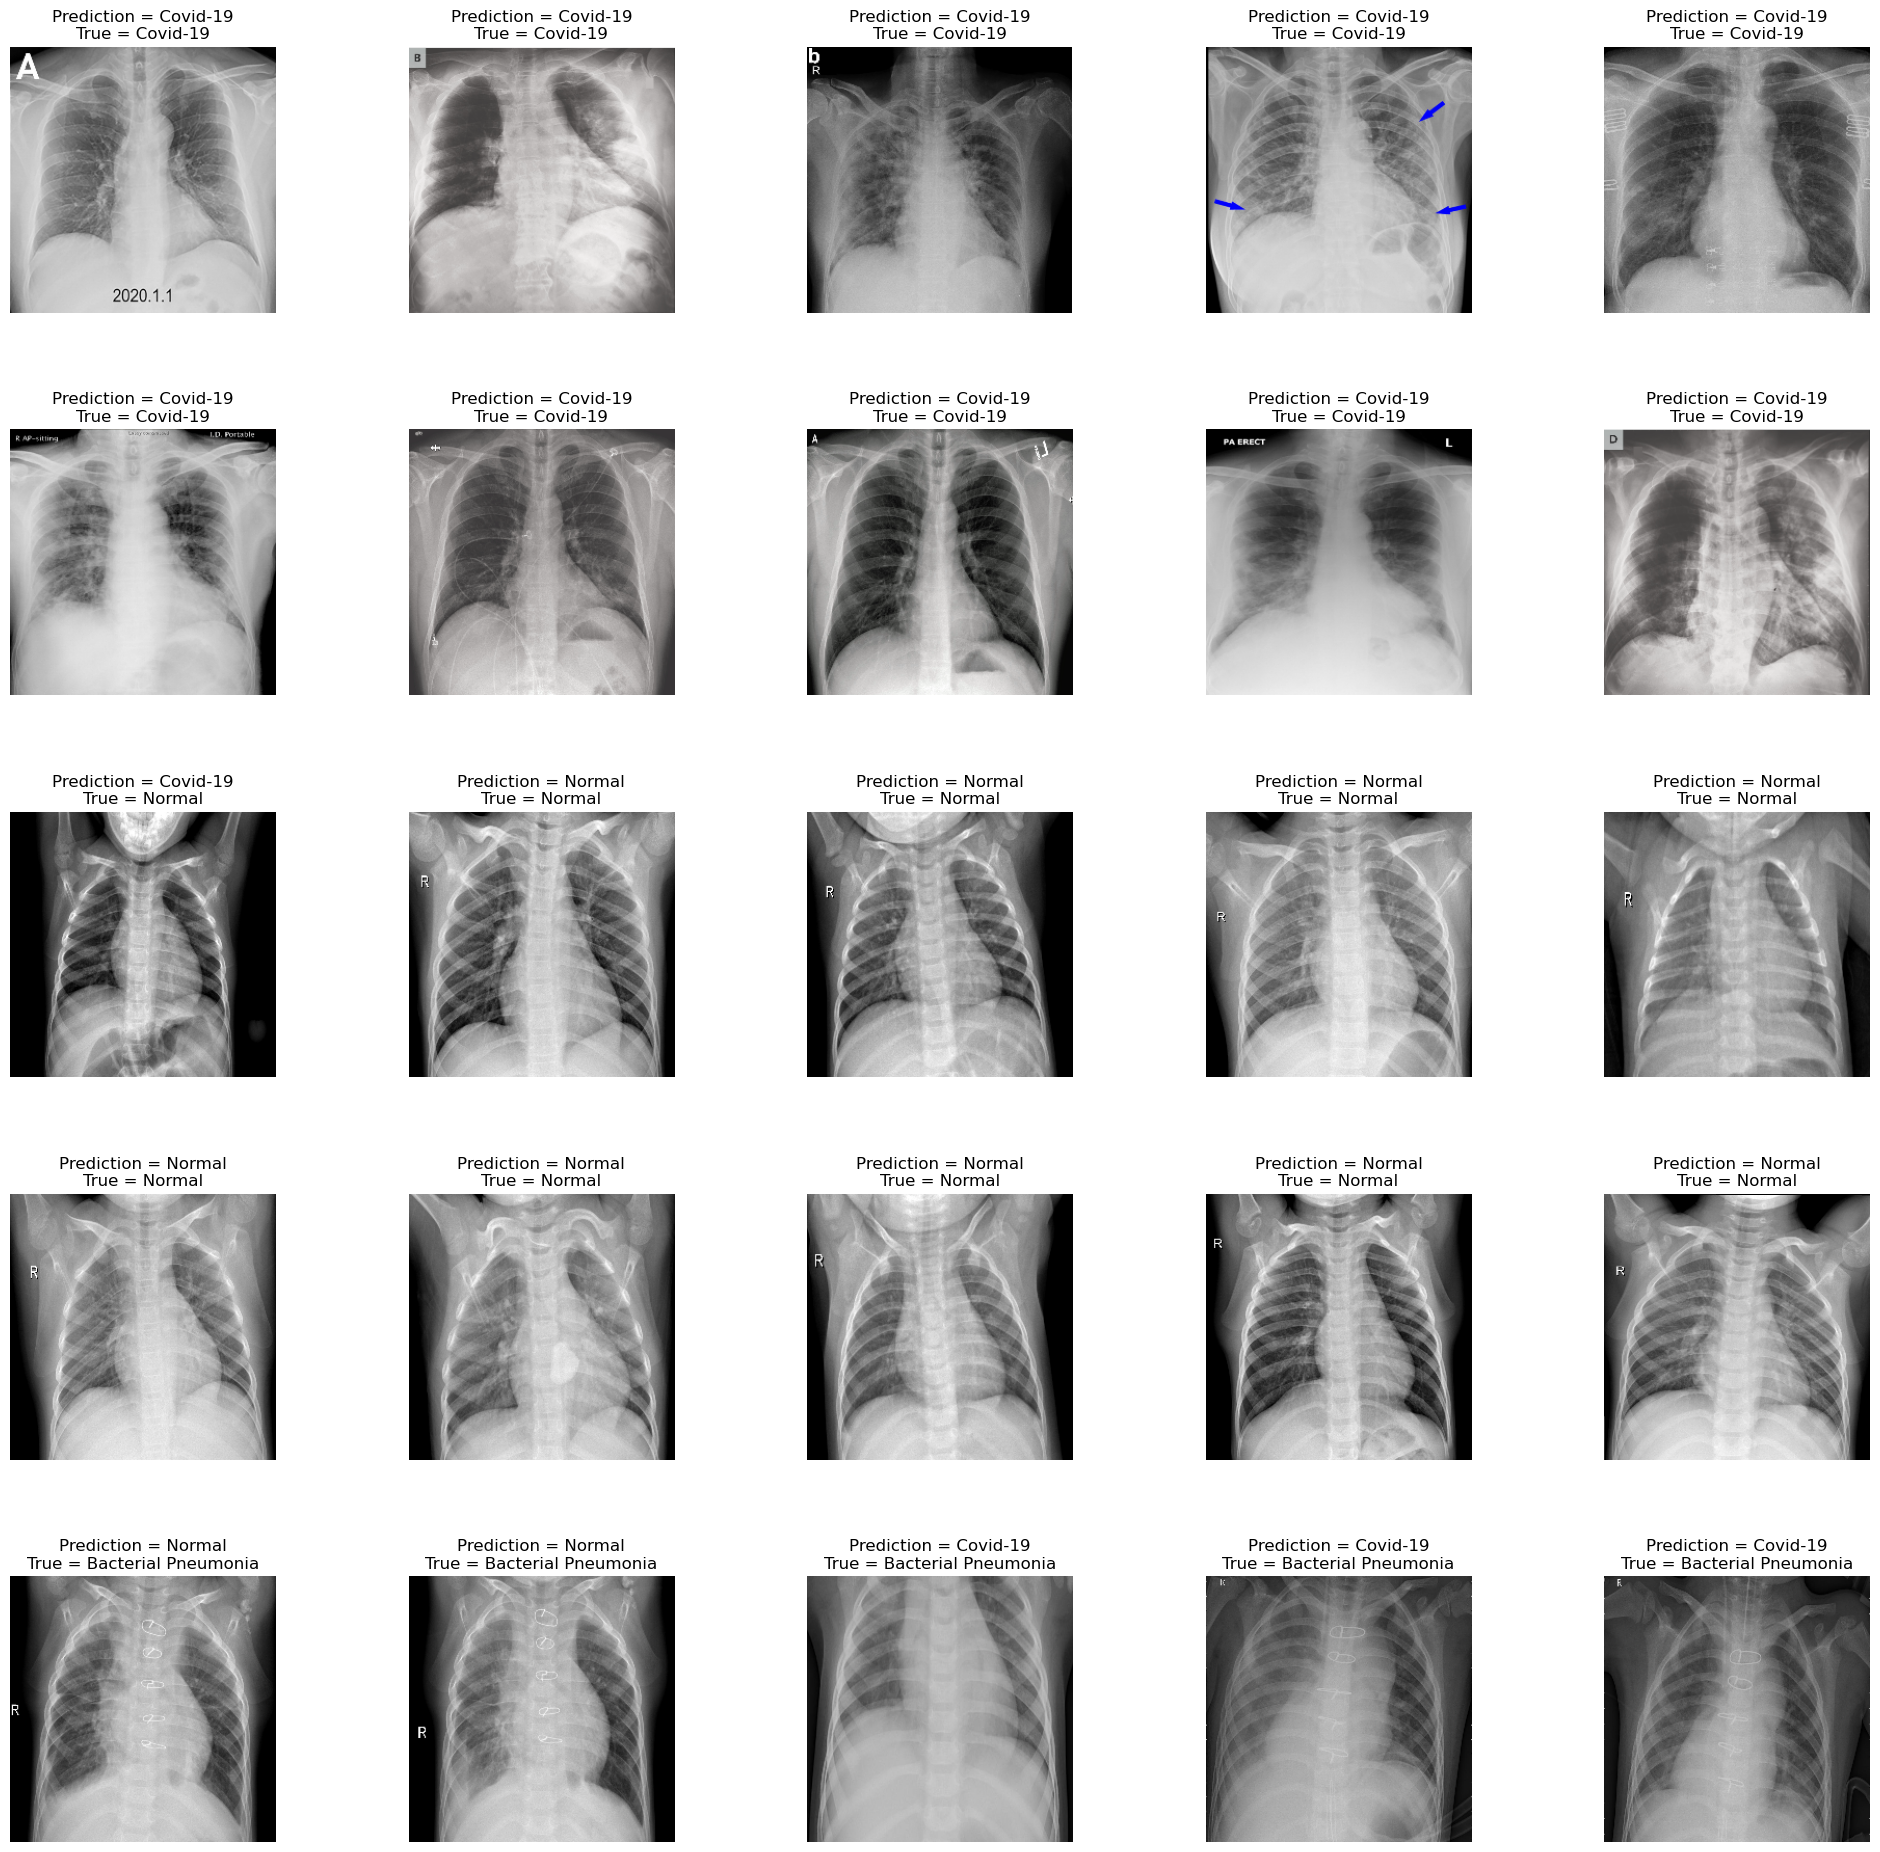

In [30]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(image[i])
    axes[i].set_title('Prediction = {}\nTrue = {}'.format(label_names[predictions[i]], label_names[original[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

In [31]:
print(classification_report(original, predictions, target_names = ['Covid-19', 'Normal', 'Viral Pneumonia', 'Bacterial Pneumonia']))

                     precision    recall  f1-score   support

           Covid-19       0.62      1.00      0.77        10
             Normal       0.60      0.90      0.72        10
    Viral Pneumonia       1.00      0.50      0.67        10
Bacterial Pneumonia       0.75      0.30      0.43        10

           accuracy                           0.68        40
          macro avg       0.74      0.67      0.65        40
       weighted avg       0.74      0.68      0.65        40



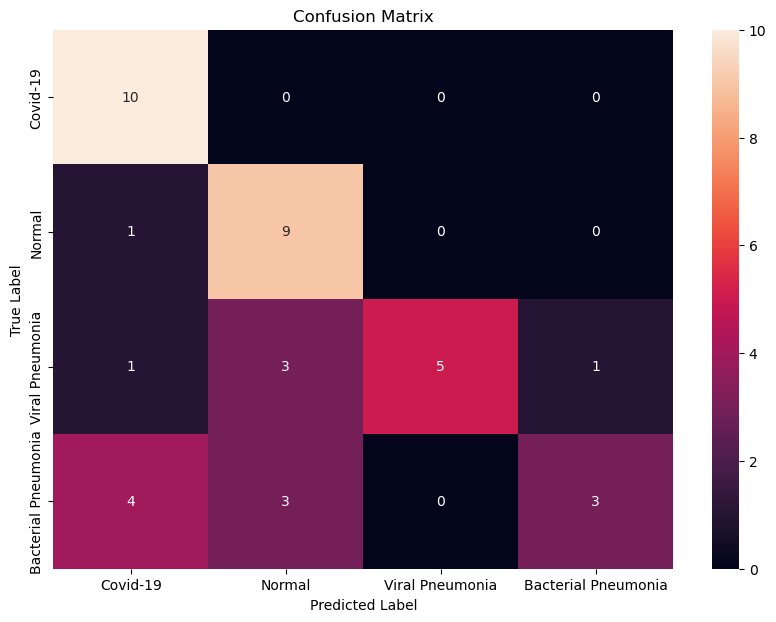

In [32]:
cm = confusion_matrix(original, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in ['Covid-19', 'Normal', 'Viral Pneumonia', 'Bacterial Pneumonia']], columns = [i for i in ['Covid-19', 'Normal', 'Viral Pneumonia', 'Bacterial Pneumonia']])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot = True, fmt = 'g')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix');

##  Conclusion:

- Ultimately the model performed fairly well on the test data achieving an accuracy of 67.5%. 
- I feel the model can be improved with a larger sample size and through fine-tuning and transforming the neural network.